# VTK Hackathon 2021 - Solutions

The goal of the Data Science task is to extract valuable insights from raw hotel rates data. The data sample is fetched from Cloud Storage for which the code is already provided below.

The data sample consists of the rates of about 7000 hotels for stay dates (the date on which you check-in) ranging from November 9 till February 6 ( a period of 90 days) as scraped on November 8. All of the rates are for stays of a single night. 



## Fetching data from Cloud Storage [Already implemented]


In [1]:
from google.cloud import storage
from google.colab import auth
import os

PROJECT_ID = 'vtkhackathon-2021'
BUCKET = 'students-public'
RATES_FILE = 'rates.csv'

if not os.path.exists(RATES_FILE):
    auth.authenticate_user()
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(BUCKET)
    blob = bucket.blob(RATES_FILE)
    blob.download_to_filename(RATES_FILE)

In [2]:
import pandas as pd
raw_rates = pd.read_csv(RATES_FILE)

## Getting to know the data [Not graded]

Some useful Pandas functions are `DataFrame.info()` , `DataFrame.describe()`, `Series.value_counts()`... See the [docs](https://pandas.pydata.org/docs/) for more information. Transform/clean the data when necessary.


In [3]:
raw_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7499736 entries, 0 to 7499735
Data columns (total 8 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   destination_name    object
 1   hotel_id            int64 
 2   stay_date           object
 3   room_name           object
 4   max_persons         int64 
 5   is_cancellable      bool  
 6   meal_type_included  object
 7   price_value         int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 407.7+ MB


In [4]:
raw_rates.hotel_id.nunique()

6970

In [5]:
raw_rates.describe()

,hotel_id,max_persons,price_value
count,7.499736e+06,7.499736e+06,7.499736e+06
mean,4.647429e+06,1.667999e+00,2.258818e+02
std,3.208089e+06,4.709315e-01,3.708133e+02
min,3.162061e+06,1.000000e+00,7.000000e+00
25%,3.196075e+06,1.000000e+00,1.080000e+02
50%,3.219199e+06,2.000000e+00,1.540000e+02
75%,3.706388e+06,2.000000e+00,2.350000e+02
max,1.881130e+07,2.000000e+00,2.509000e+04


In [6]:
raw_rates.max_persons.value_counts()

2    5009813
1    2489923
Name: max_persons, dtype: int64

In [7]:
raw_rates.meal_type_included.value_counts()

BREAKFAST    4110198
NONE         3079331
HALFBOARD     277734
ALLIN          18704
FULLBOARD      13769
Name: meal_type_included, dtype: int64

In [8]:
# Changing data type to datetime
raw_rates['stay_date'] = pd.to_datetime(raw_rates['stay_date'])

In [9]:
raw_rates.isnull().sum()

destination_name      0
hotel_id              0
stay_date             0
room_name             0
max_persons           0
is_cancellable        0
meal_type_included    0
price_value           0
dtype: int64

## Task 1: Exceptional deals
As some hotel managers manually adjust prices, mistakes are bound to happen. The task is for you to robustly identify these outliers (so you could exploit them to get a cheap stay).

Just taking the minimum over price values will of course not lead to these cases as €8 for a dormitory bed in Bulgaria might not be that exceptional, while a €25 suite in a 5 star hotel in Brussels probably is. The prices should thus be normalized to a `price index` indicating how exceptional the price is.

**Grading: Provide us with the (our_hotel_id, stay_date) of the most significant outlier**

Hint 1: For aggregations, see the Pandas docs on [DataFrame.groupby()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [named aggregation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#named-aggregation).

Hint 2: When you have found an outlier, plot the price value of this offer over all stay dates to see if it is really a valuable outlier.


In [10]:
config_columns = [
    "hotel_id",
    "room_name",
    "max_persons",
    "is_cancellable",
    "meal_type_included",
]
config_columns_small = [
    "room_name",
    "max_persons",
    "is_cancellable",
    "meal_type_included",
]

In [11]:
# Calculating stats per config by .groupby and .agg
stats = raw_rates.groupby(config_columns).agg(price_value_050 = ('price_value','median'), price_value_avg = ('price_value','mean'), price_value_010 = ('price_value',lambda x: x.quantile(0.1))).reset_index()


In [12]:
# Normalizing price value to price indexes using the stats per config
price_indexes = stats.merge(raw_rates, how="left", on=config_columns)
price_indexes.loc[:, "price_index_avg"] = price_indexes.price_value / price_indexes.price_value_avg
price_indexes.loc[:, "price_index_010"] = price_indexes.price_value / price_indexes.price_value_010
price_indexes.loc[:, "price_index_050"] = price_indexes.price_value / price_indexes.price_value_050

In [13]:
price_indexes.sort_values("price_index_avg").iloc[:3]

,hotel_id,room_name,max_persons,is_cancellable,meal_type_included,price_value_050,price_value_avg,price_value_010,destination_name,stay_date,price_value,price_index_avg,price_index_010,price_index_050
4155983,3240495,Single Bed in 3-Bed Female Dormitory,1,True,NONE,21.0,222.019231,15.0,Valencia (ES),2022-01-10,14,0.063058,0.933333,0.666667
4155987,3240495,Single Bed in 3-Bed Female Dormitory,1,True,NONE,21.0,222.019231,15.0,Valencia (ES),2022-01-18,14,0.063058,0.933333,0.666667
4155962,3240495,Single Bed in 3-Bed Female Dormitory,1,True,NONE,21.0,222.019231,15.0,Valencia (ES),2022-01-17,14,0.063058,0.933333,0.666667


In [14]:
import matplotlib.pyplot as plt
def plot_best_hotel_config(df, sort_column): 
  """Function to plot the 'best' outlier price value according to a selected method (i.e. the sort_column)"""
  best_config = df.sort_values(sort_column).iloc[0]
  print(best_config)
  selected_rates = best_config[config_columns].to_frame().T.merge(df, how="left", on=config_columns)
  selected_rates.plot(x="stay_date", y="price_value")
  plt.savefig(f'best_config_{sort_column}.png')
  plt.show()


hotel_id                                           3240495
room_name             Single Bed in 3-Bed Female Dormitory
max_persons                                              1
is_cancellable                                        True
meal_type_included                                    NONE
price_value_050                                         21
price_value_avg                                    222.019
price_value_010                                         15
destination_name                             Valencia (ES)
stay_date                              2022-01-10 00:00:00
price_value                                             14
price_index_avg                                  0.0630576
price_index_010                                   0.933333
price_index_050                                   0.666667
Name: 4155983, dtype: object


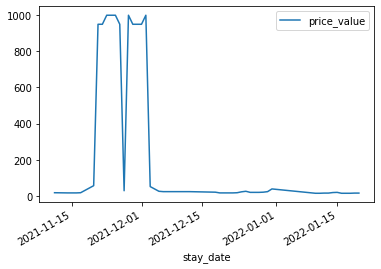

In [15]:
# trying price index based on normalization by average
plot_best_hotel_config(price_indexes, 'price_index_avg')

Low index on some stays dates seems to be caused by high outliers on others. Avg is not a robust way to determine the normal price.

hotel_id                          3162125
room_name                     Single Room
max_persons                             1
is_cancellable                       True
meal_type_included                   NONE
price_value_050                      1056
price_value_avg                   612.362
price_value_010                        87
destination_name           Amsterdam (NL)
stay_date             2021-11-10 00:00:00
price_value                            76
price_index_avg                  0.124109
price_index_010                  0.873563
price_index_050                 0.0719697
Name: 34097, dtype: object


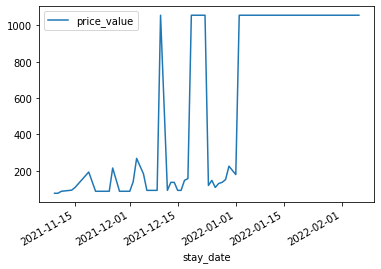

In [16]:
# trying price index based on normalization by median
plot_best_hotel_config(price_indexes, 'price_index_050')

hotel_id                               3790173
room_name             Suite with Terrace 40 m²
max_persons                                  1
is_cancellable                            True
meal_type_included                   BREAKFAST
price_value_050                            100
price_value_avg                        102.431
price_value_010                             90
destination_name                 Istanbul (TR)
stay_date                  2022-01-04 00:00:00
price_value                                 13
price_index_avg                       0.126915
price_index_010                       0.144444
price_index_050                           0.13
Name: 5713297, dtype: object


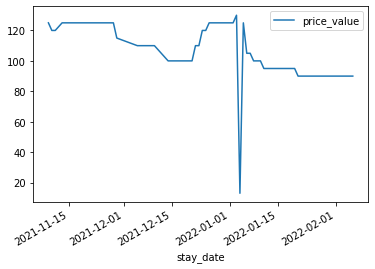

In [17]:
# trying price index based on normalization by 10th percentile price value
plot_best_hotel_config(price_indexes, 'price_index_010')

In [18]:
def hotel_checker(df, hotel_id):
    """Function to plot the price value per stay date for all configs of a hotel.
    Different configs are plotted in different plots """
    df1 = df[df.hotel_id == hotel_id].copy()
    for room_name in df1.room_name.unique():
        df2 = df1[df1.room_name == room_name].copy()
        for max_persons in df2.max_persons.unique():
            df3 = df2[df2.max_persons == max_persons].copy()
            for meal_type_included in df3.meal_type_included.unique():
                df4 = df3[df3.meal_type_included == meal_type_included].copy()
                for is_cancellable in df4.is_cancellable.unique():
                    df5 = df4[df4.room_name == room_name].copy()
                    print(room_name, max_persons, meal_type_included, is_cancellable)                    
                    df5.plot(x="stay_date", y="price_value")
                    plt.show()

Studio 1 BREAKFAST False


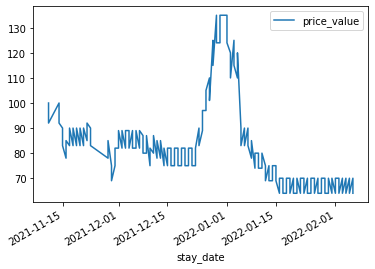

Studio 1 BREAKFAST True


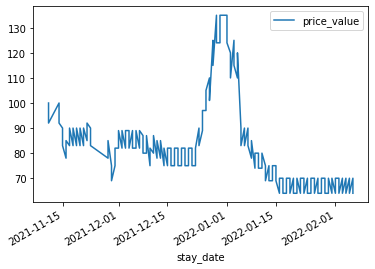

Studio 2 BREAKFAST False


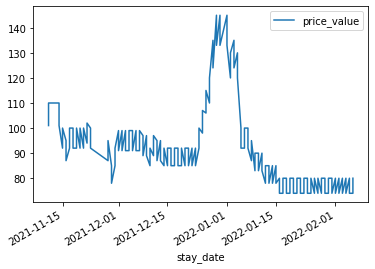

Studio 2 BREAKFAST True


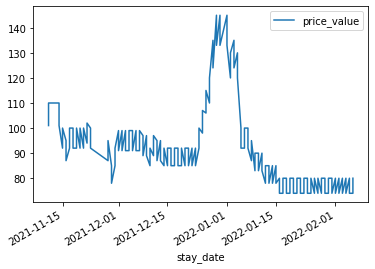

Suite with Balcony - Additional Building 1 BREAKFAST False


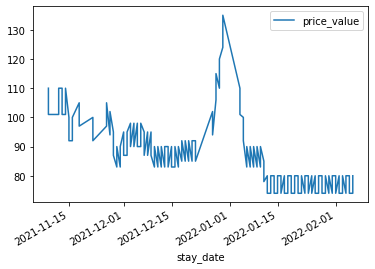

Suite with Balcony - Additional Building 1 BREAKFAST True


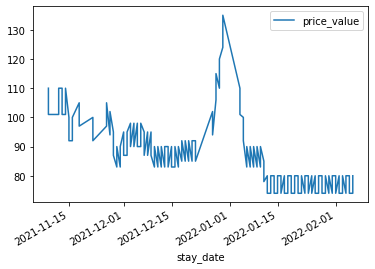

Suite with Balcony - Additional Building 2 BREAKFAST False


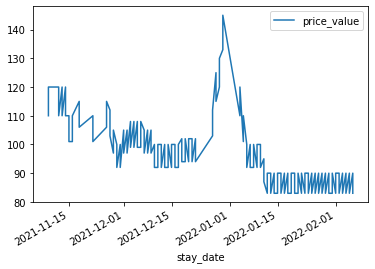

Suite with Balcony - Additional Building 2 BREAKFAST True


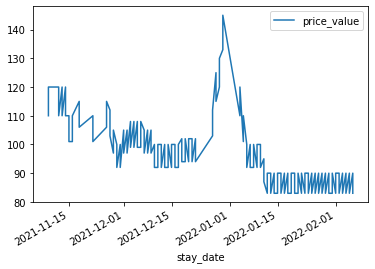

Suite with Terrace 40 m² 1 BREAKFAST False


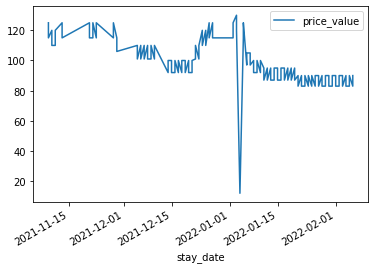

Suite with Terrace 40 m² 1 BREAKFAST True


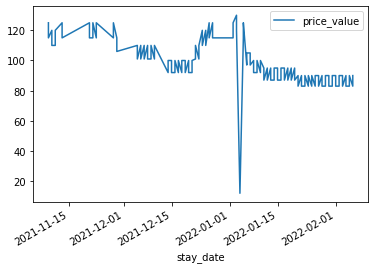

Suite with Terrace 40 m² 2 BREAKFAST False


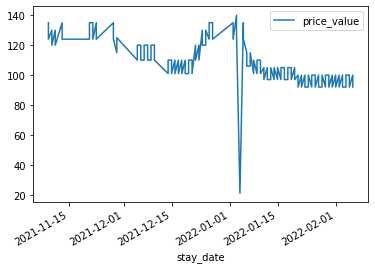

Suite with Terrace 40 m² 2 BREAKFAST True


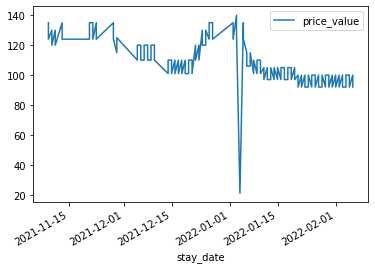

In [19]:
hotel_checker(price_indexes, 3790173)

## Task 2: Patterns per destination 

From the price indexes you calculated in the previous task you can get information on the pricing patterns per destination. For this task we ask you to calculate the business leisure score according to the following steps:

1. go from the price index per (hotel, config, stay date) to a price index per (hotel, stay date).
2. go from the price index per (hotel, stay date) to a price index per (destination, stay date)
3. go from the price index per (destination id, stay date) to a price index per (destination, day of week)
4. create a business/leisure score by using the price indexes on business days (Sunday till Thursday) and the price indexes on leisure days (=Friday and Saturday)

For aggregations, you can use medians.

**Grading: Plot the price index per (destination, day of week) for the destination with the lowest and the destination with the highest leisure/business index**

In [20]:
price_index_per_hotel = (price_indexes
                         .groupby(['destination_name', 'hotel_id', 'stay_date'])
                         .price_index_010.median()
                         .to_frame()
                         .reset_index()
                         )

In [21]:
price_index_destination = (price_index_per_hotel
                           .groupby(['destination_name', 'stay_date'])
                           .price_index_010
                           .median()
                           .to_frame()
                           .reset_index()
                           )

In [22]:
price_index_destination['dayofweek'] = price_index_destination.stay_date.dt.dayofweek

In [23]:
price_index_per_destination_dow = (price_index_destination
                                   .groupby(['destination_name', 'dayofweek'])
                                   .price_index_010
                                   .median()
                                   .to_frame()
                                   .reset_index()
)

In [24]:
price_index_per_destination_dow['day_type'] = (price_index_per_destination_dow['dayofweek']
                                               .map(lambda x: 'weekend' if x in [4,5] else 'weekday')
                                               )

In [25]:
price_index_per_destination_day_type = (price_index_per_destination_dow
                                        .groupby(['destination_name', 'day_type'])
                                        .price_index_010
                                        .median()
                                        .to_frame()
                                        .reset_index()
                                        )

In [26]:
price_index_per_destination_day_type_pivoted = (price_index_per_destination_day_type
                                                .pivot(index = 'destination_name', columns = 'day_type', values='price_index_010')
                                                .reset_index()
                                                )
price_index_per_destination_day_type_pivoted['business_leisure_index'] = (price_index_per_destination_day_type_pivoted.weekday/
                                                                          price_index_per_destination_day_type_pivoted.weekend
                                                                          )
price_index_per_destination_day_type_pivoted = (price_index_per_destination_day_type_pivoted
                                                .sort_values('business_leisure_index')
                                                )
price_index_per_destination_day_type_pivoted.columns.name = ''
price_index_per_destination_day_type_pivoted.reset_index(inplace=True, drop=True)


In [27]:
price_index_per_destination_day_type_pivoted

,destination_name,weekday,weekend,business_leisure_index
0,Dublin (IE),1.058533,1.523248,0.694918
1,Prague (CZ),1.057695,1.365881,0.774369
2,Amsterdam (NL),1.058354,1.340827,0.789329
3,Salzburg (AT),1.069687,1.346901,0.794184
4,Malaga (ES),1.062041,1.279768,0.829870
5,Venice (IT),1.041271,1.239015,0.840402
6,Sevilla (ES),1.050663,1.219044,0.861875
7,Vienna (AT),1.069956,1.238276,0.864069
8,Antwerp (BE),1.066667,1.210632,0.881082
9,Hamburg (DE),1.069218,1.206454,0.886248


### Solution

In [28]:
top_destinations = (price_index_per_destination_day_type_pivoted
                    .destination_name
                    .values[[0,-1]]
                    )

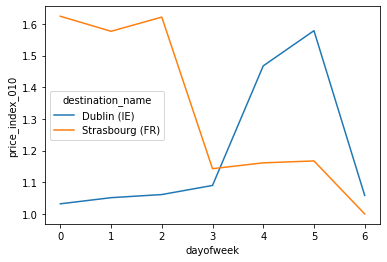

In [29]:
import seaborn as sns
sns.lineplot(data = price_index_per_destination_dow[price_index_per_destination_dow.destination_name.isin(top_destinations)],
             x='dayofweek', 
             y= 'price_index_010', 
             hue = 'destination_name')
plt.savefig('destination_patterns.png')
plt.show()